In [1]:
import numpy as np
import os
from tensorflow.keras import models, layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import img_to_array
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import backend as K
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn import metrics
import seaborn as sns

In [2]:
INIT_LR = 1e-3
BATCH_SIZE = 32
EPOCHS = 10
IMAGE_SIZE = 256
default_image_size = tuple((IMAGE_SIZE, IMAGE_SIZE))
image_size = 0
data_dir = './All-20230430T073321Z-001/All/'
CHANNELS=3
AUTOTUNE = tf.data.AUTOTUNE
class_names = ["GLS", "CR", "NLB", ""]

In [3]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = ds.cardinality().numpy()
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [4]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  seed=123,
  image_size=default_image_size,
  batch_size=BATCH_SIZE
)


train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

Found 2352 files belonging to 4 classes.


In [5]:
interpreter = tf.lite.Interpreter(model_path="Salinan DLmodel.tflite")
interpreter.allocate_tensors()

# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
print(input_details)

[{'name': 'serving_default_sequential_input:0', 'index': 0, 'shape': array([  1, 256, 256,   3]), 'shape_signature': array([ -1, 256, 256,   3]), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]


In [6]:
y_predict = []  
y_test = [] 

for image_batch, label_batch in val_ds:   # use dataset.unbatch() with repeat
    for label in label_batch:
        y_test.append(label.numpy())
    for image in image_batch:
        x = np.expand_dims(image, axis=0)  # Use only the first image and add a batch dimension
        interpreter.set_tensor(input_details[0]['index'], x)
        interpreter.invoke()
        output = interpreter.get_tensor(output_details[0]['index'])
        y_predict.append(np.argmax(output, axis=-1))

y_predict = [i.tolist()[0] for i in y_predict]

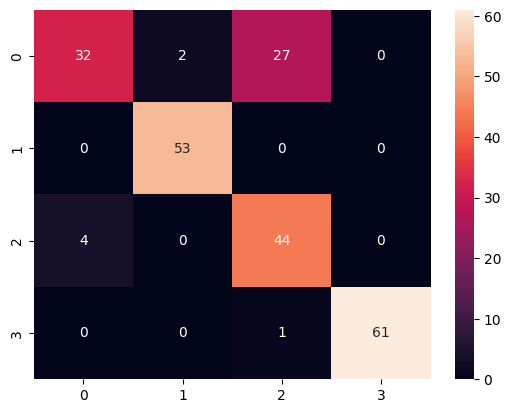

In [7]:
cm = confusion_matrix(y_pred=y_predict, y_true=y_test)
f = sns.heatmap(cm, annot=True)

In [9]:
print(metrics.classification_report(y_pred=y_predict, y_true=y_test, digits=3))

              precision    recall  f1-score   support

           0      0.889     0.525     0.660        61
           1      0.964     1.000     0.981        53
           2      0.611     0.917     0.733        48
           3      1.000     0.984     0.992        62

    accuracy                          0.848       224
   macro avg      0.866     0.856     0.842       224
weighted avg      0.878     0.848     0.844       224

